In [1]:
#Import Modules


#GPyOpt
import GPyOpt
from GPyOpt.methods import BayesianOptimization


#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.models import AdjointSimpleODEModel as ODEModel #Model module builds basic pa
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindFixU #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Generate Observations Using Physical Model

### Generate Training and Testing Sensor Locations

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,9,5) # lower time
xloc=np.linspace(1.5,7.5,4) # x locations
yloc=np.linspace(1.5,7.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

### Run Forward Model to Compute Concentration

In [3]:
# Parameters to be inferred
k_0 = 0.15#Diffusion
R=1
l=1.0
sigma2=2.0


k = EQ(l,sigma2) # generate EQ kernel arguments are lengthscale and variance
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
u=[]
#u.append(np.ones(res)*wind) #x direction wind
#u.append(np.ones(res)*0.0) # y direction wind

u.append(np.ones(res)*0.01) #x direction wind
u.append(np.ones(res)*0.01) # y direction wind
windmodel=WindFixU(u) # establish fixed wind model


m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

### Generate Training and Testing Data

In [4]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

## Bayesian Optimisation

In [5]:
N_feat =10

k_02 = np.linspace(2,5,10)
MSE = np.zeros(len(k_02))
sources =[]
reps = 100
var = np.ones(len(yTest))*noiseSD**2
llObs = 0
k2 = EQ(l,sigma2)
m1 = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model

def obj_funcVar(x):
    llObs = 0
    m1.kernel.sigma2=x 
    m1.sensormodel=sensors
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcLength(x):
    llObs = 0
    m1.kernel.l2=x 
    m1.sensormodel=sensors
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcReact(x):
    llObs = 0
    m1.R=x 
    m1.sensormodel=sensors
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcDiff(x):
    llObs = 0
    m1.k_0=x
    m1.sensormodel=sensors
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcLengthVar(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    llObs = 0
    m1.sensormodel=sensors
    m1.kernel.l2=x1
    m1.kernel.sigma2=x2
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcLengthVarDiffReact(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    x3 = x[:, 2]
    x4 = x[:, 3]
    llObs = 0
    m1.sensormodel=sensors
    m1.kernel.l2=x1
    m1.kernel.sigma2=x2
    m1.k_0=x3
    m1.R=x4
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcLengthDiff(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    llObs = 0
    
    k = EQ(x1, 2) # generate EQ kernel
    m1 = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors16,u=u,k_0=10**x2) #initiate PDE model
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        m1.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        m1.sensormodel=sensorsTest
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

# Estimate Kernel Lengthscale

In [6]:

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (1,10)}]


myBopt_l = BayesianOptimization(f=obj_funcLength, domain=domain,acquisition_type='EI')
myBopt_l.run_optimization(max_iter=50)


Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 


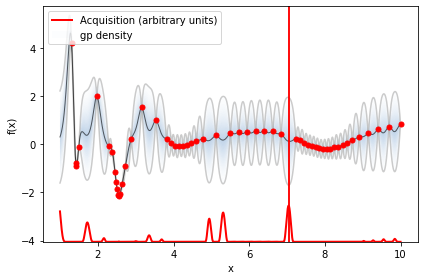

In [7]:
myBopt_l.plot_acquisition()

In [8]:
print("The minumum value obtained by the function was %.4f (x = %.4f)" % (myBopt_l.fx_opt, myBopt_l.x_opt))

The minumum value obtained by the function was 6831.4885 (x = 2.5637)


# Estimate Kernel Variance

In [9]:

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (1,10)}]


myBopt_v = BayesianOptimization(f=obj_funcVar, domain=domain)
myBopt_v.run_optimization(max_iter=50)


Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 


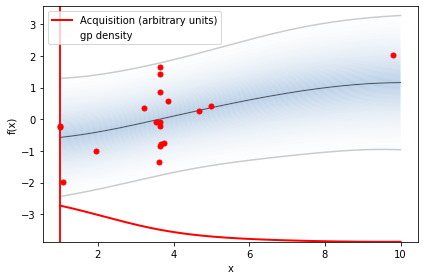

In [10]:
myBopt_v.plot_acquisition()

In [11]:
print("The minumum value obtained by the function was %.4f (x = %.4f)" % (myBopt_v.fx_opt, myBopt_v.x_opt))

The minumum value obtained by the function was 7123.1286 (x = 1.0924)


# Estimate Diffusion Coefficient

In [12]:

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (1e-3,1e-1)}]


myBopt_d = BayesianOptimization(f=obj_funcDiff, domain=domain)
myBopt_d.run_optimization(max_iter=50)

Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 


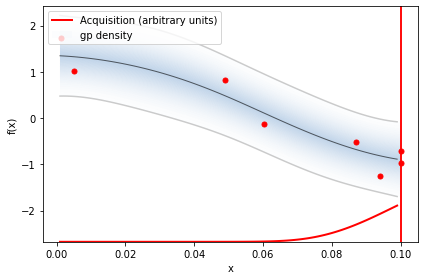

In [13]:
myBopt_d.plot_acquisition()

In [14]:
print("The minumum value obtained by the function was %.4f (x = %.4f)" % (myBopt_d.fx_opt, myBopt_d.x_opt))

The minumum value obtained by the function was 7111.6526 (x = 0.0940)


# Estimate Reaction Coefficient

In [15]:
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (1e-5,10)}]


myBopt_R = BayesianOptimization(f=obj_funcReact, domain=domain)
myBopt_R.run_optimization(max_iter=50)

Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 


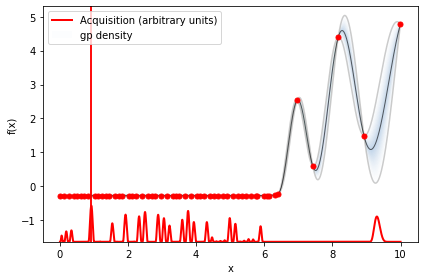

In [16]:
myBopt_R.plot_acquisition()

In [17]:
print("The minumum value obtained by the function was %.4f (x = %.4f)" % (myBopt_R.fx_opt, myBopt_R.x_opt))

The minumum value obtained by the function was 6691.9557 (x = 4.3986)


# Infer Entire Kernel

In [18]:
bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (1,10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (1,10)}]
maxiter = 100

myBopt_2d = GPyOpt.methods.BayesianOptimization(obj_funcLengthVar, domain=bounds2d)
myBopt_2d.run_optimization(max_iter = maxiter)

Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 


Value of (x,y) that minimises the objective:[2.44690669 5.12235554]
Minimum value of the objective: 7096.434793547071


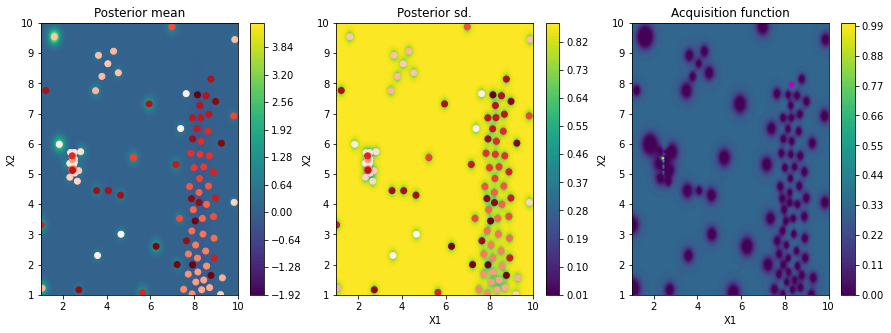

In [19]:
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()

In [20]:
bounds4d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_3', 'type': 'continuous', 'domain': (1e-5,1)},
            {'name': 'var_4', 'type': 'continuous', 'domain': (0,5)}]
maxiter = 100

myBopt_4d = GPyOpt.methods.BayesianOptimization(obj_funcLengthVarDiffReact, domain=bounds4d)
myBopt_4d.run_optimization(max_iter = maxiter)

Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 
Calculating Phis...
9/10 
Calculating Adjoints...
47/48 


In [21]:
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_4d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_4d.fx_opt))     
print("="*20)
myBopt_4d.plot_acquisition()

Value of (x,y) that minimises the objective:[1.18301455e+00 3.02635123e+00 1.00000000e-05 0.00000000e+00]
Minimum value of the objective: 6054.175601146101
